In [ ]:
from main import *
from useful_functions import *
from visualization import *
from stats import *

%matplotlib inline
plt.rcParams['font.size'] = 18

# Setting paths

In [2]:
top_directory = '/media/anleg84/Backup Plus/CERVO/Data/Networks2024/'
atlas_path = '/home/anleg84/Documents/Atlas/Mapzebrain/'

atlas = MapzebrainAtlas(atlas_path)

In [3]:
def get_datasets(top_directory, keywords=[], exclude=[]):
    folders = identify_folders(top_directory, ['dpf'])
    datasets = []
    for folder in folders:
        datasets += identify_folders(folder, keywords=keywords, exclude=exclude)
    return datasets

In [4]:
datasets = get_datasets(top_directory, keywords=['920nm'])

folders = []
for ds in datasets:
    if any(identify_files(ds, ['tail', 'angles', '.npy'])):
        folders.append(ds)

# Part 1 - Regression

### Plotting motor traces

We begin by loading and plotting the motor activity traces. More specifically, we plot the cumulative tail angle by summing angles over the 10 tail segments. Note that not all fish have motor recordings.

In [5]:
tails, folders = [], []

for ds in datasets:
    if any(identify_files(ds, ['tail', 'angles', '.npy'])):
        file = identify_files(ds, ['tail', 'angles', '.npy'])[0]
        angles = np.load(ds + file)
        tail = TailAnalysis(angles, 399.75)
        tails.append(tail)
        folders.append(ds)

In [ ]:
for i, tail in enumerate(tails):
    print(i, folders[i])
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(tail.curvature, color='black')
    ax.spines[['top', 'right']].set_visible(False)
    ax.set_xlabel('Camera frames')
    ax.set_ylabel('Cumulative tail angle')
    plt.show()

## Identifying swim events

Next, we load our pretrained RNN model and use it to automatically detect swimming events. The model takes into account all tail segments simultaneously, not just the cumulative trace.

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [8]:
def identify_swim_events(angles, model):
    inputs = torch.unsqueeze(torch.tensor(np.swapaxes(angles, 0, 1), dtype=torch.float32), axis=0)
    outputs = model(inputs).detach().cpu().numpy()
    return outputs[0, :, 0]

class GRUModel(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True, num_layers=num_layers)
        self.w_out = nn.Parameter(torch.randn(hidden_size, 1), requires_grad=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        output_raw, _ = self.gru(x)
        output = self.sigmoid(torch.matmul(output_raw, self.w_out))
        return output

def exclude_short_events(binary_events, length_threshold):
    plateaus = find_plateaus(binary_events)
    too_short = np.sum(plateaus, axis=1) <= length_threshold
    plateaus = plateaus[np.logical_not(too_short)]
    vector = np.sum(plateaus, axis=0)
    return vector

In [9]:
model = torch.load('Data/swimdetector_64units.pth')

In [10]:
compute = False

events = []
if compute:
    for tail in tqdm(tails, file=sys.stdout):
        output = identify_swim_events(tail.angles, model)
        events.append(output)

In [11]:
save = False

if save:
    for i in range(len(folders)):
        folder = folders[i]
        event_vector = events[i]
        np.save(folder + 'swim_events.npy', event_vector)

When we load the events, which are vectors of probabilities, we first threshold them at $P=0.5$ (which is the threshold used during training to yield binary segmentations) and we shift the model outputs by 15 time steps, which reverses a similar shift introduced during training. The reason for this is because the RNN model treats the temporal signals in a forward manner and is only reactive to the swimming events. In other words, it cannot identify precisely the swimming onset times before any tail movement has occurred. We thus trained the model to yield a delayed output, giving it enough time to integrate signals and report the presence of swimming a posteriori.

In [12]:
load = True

if load:
    events = []
    for f in folders:
        vector = (np.load(f + 'swim_events.npy') > 0.5).astype('int')[15:]
        vector = np.concatenate([vector, [0] * 15]) # Shifting model outputs by 15 time steps
        if len(vector) != 360000:
            vector = np.concatenate([vector, [0] * (360000 - len(vector))])
        events.append(vector)

0 /media/anleg84/Backup Plus/CERVO/Data/Networks2024/20230725-Wholebrain-6dpf/20230725_12_39_26_920nm_6dpf_fish1_wholebrain/


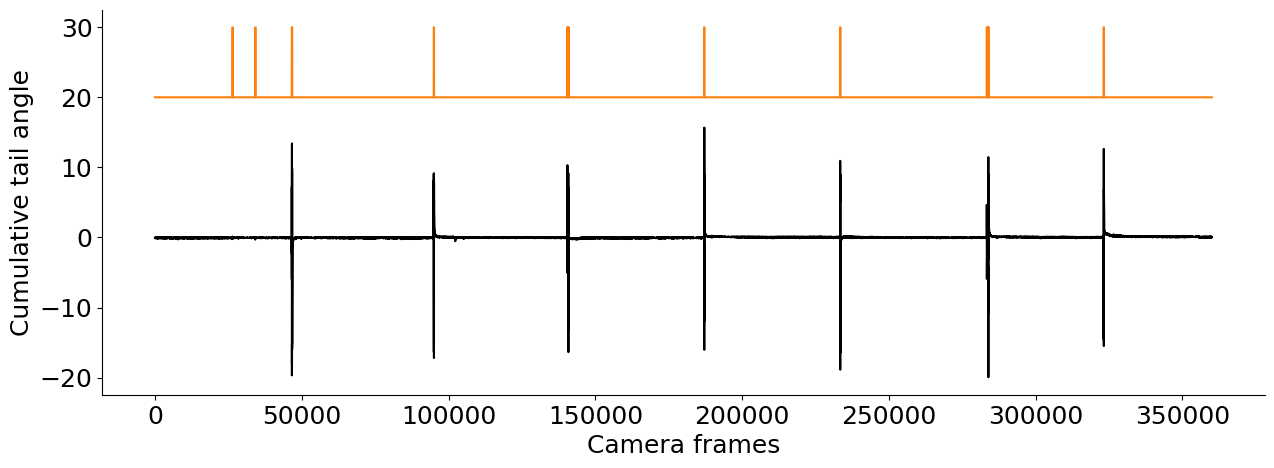

1 /media/anleg84/Backup Plus/CERVO/Data/Networks2024/20230725-Wholebrain-6dpf/20230725_16_19_46_920nm_6dpf_fish2_wholebrain/


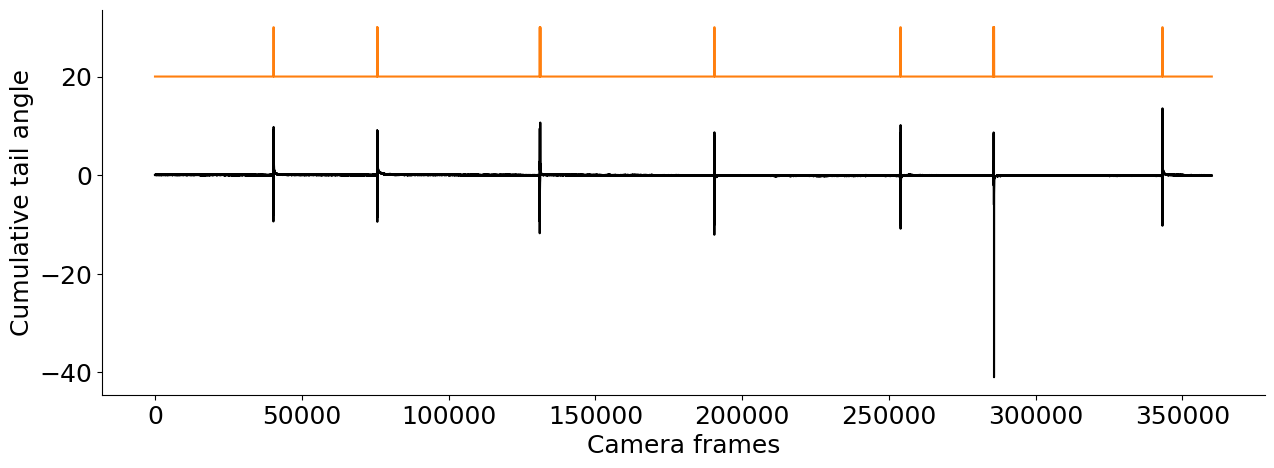

2 /media/anleg84/Backup Plus/CERVO/Data/Networks2024/20230725-Wholebrain-6dpf/20230725_17_27_08_920nm_6dpf_fish4_wholebrain/


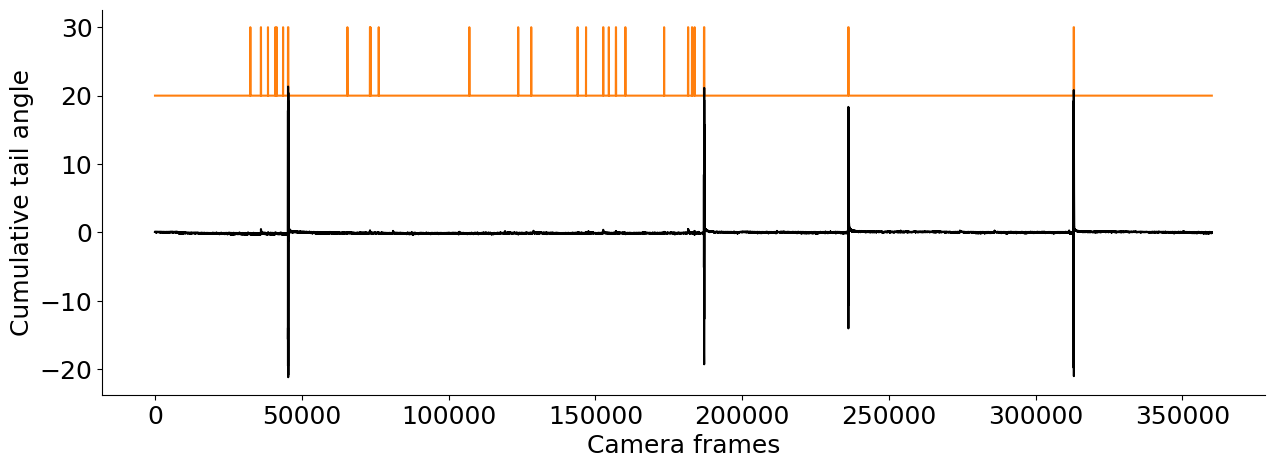

3 /media/anleg84/Backup Plus/CERVO/Data/Networks2024/20230725-Wholebrain-6dpf/20230725_19_15_44_920nm_6dpf_fish6_wholebrain/


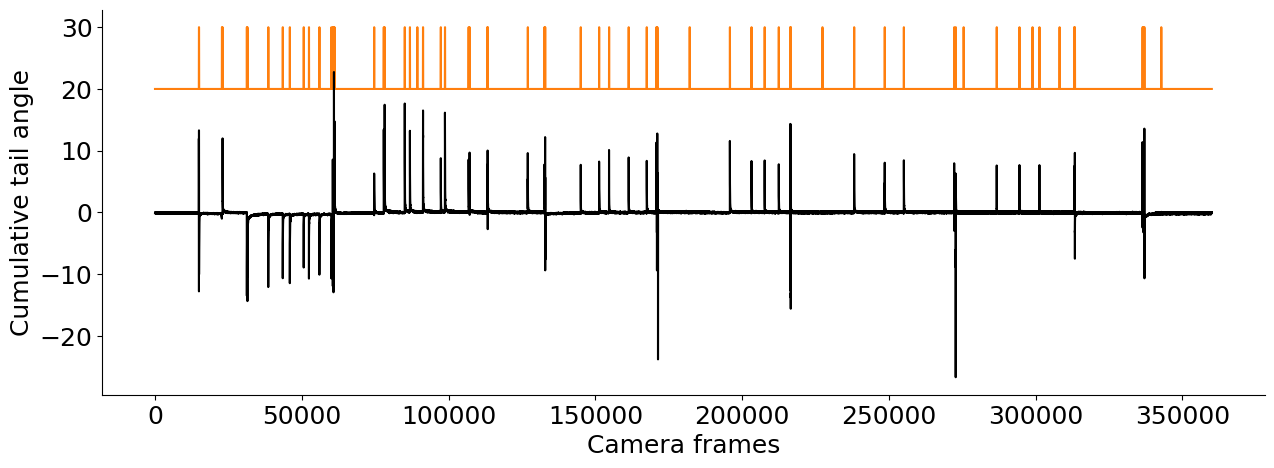

4 /media/anleg84/Backup Plus/CERVO/Data/Networks2024/20230726-Wholebrain-7dpf/20230726_14_59_58_920nm_7dpf_fish2_wholebrain/


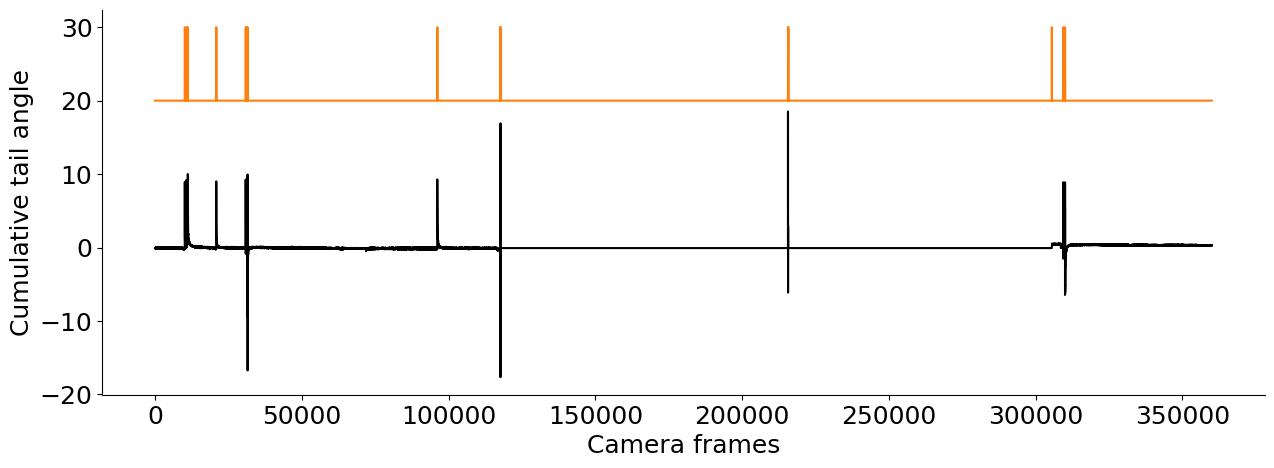

5 /media/anleg84/Backup Plus/CERVO/Data/Networks2024/20230726-Wholebrain-7dpf/20230726_15_40_59_920nm_7dpf_fish3_wholebrain/


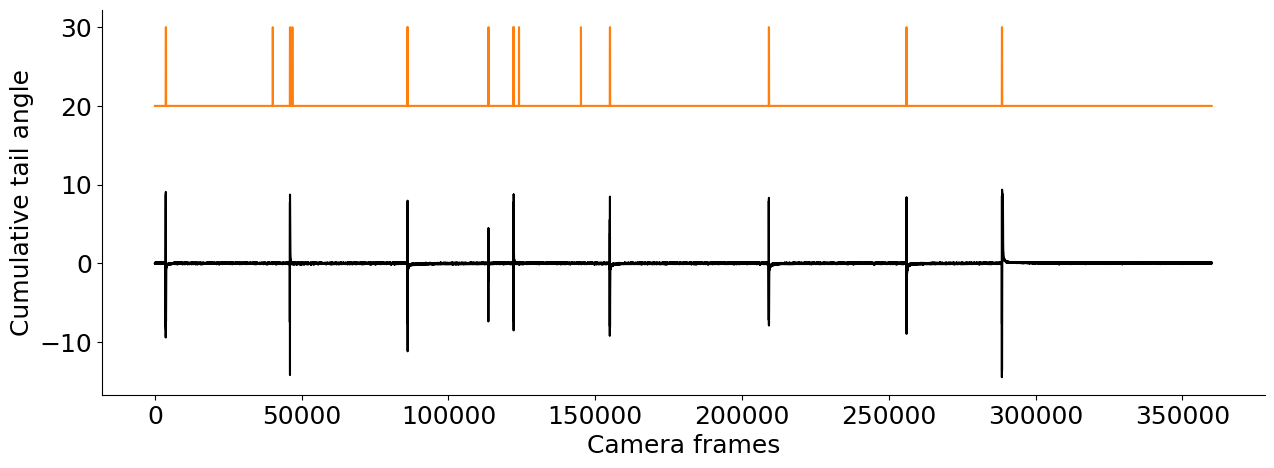

6 /media/anleg84/Backup Plus/CERVO/Data/Networks2024/20230726-Wholebrain-7dpf/20230726_16_13_39_920nm_7dpf_fish4_wholebrain/


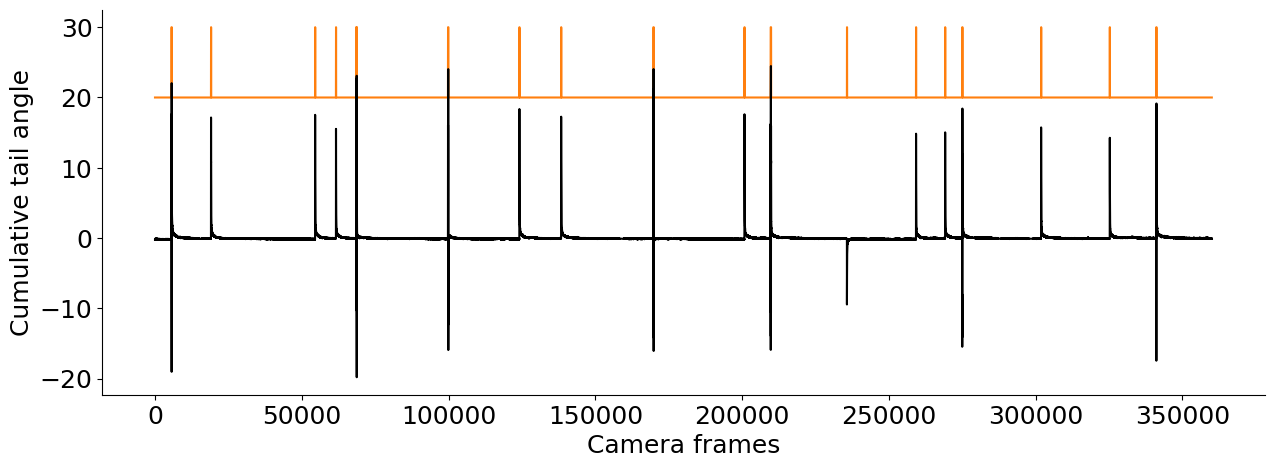

7 /media/anleg84/Backup Plus/CERVO/Data/Networks2024/20230726-Wholebrain-7dpf/20230726_17_21_03_920nm_7dpf_fish5_wholebrain/


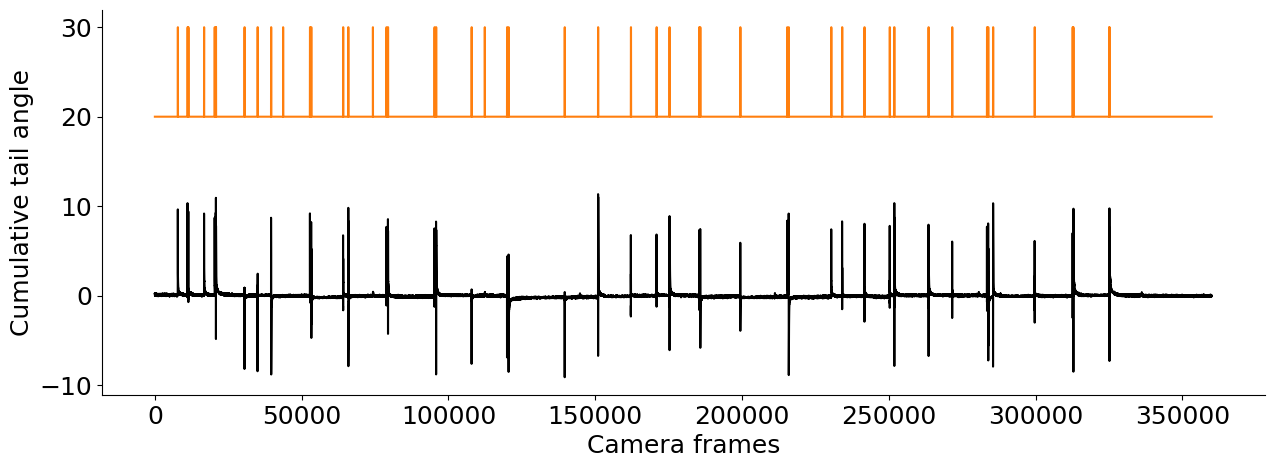

8 /media/anleg84/Backup Plus/CERVO/Data/Networks2024/20230726-Wholebrain-7dpf/20230726_17_52_54_920nm_7dpf_fish6_wholebrain/


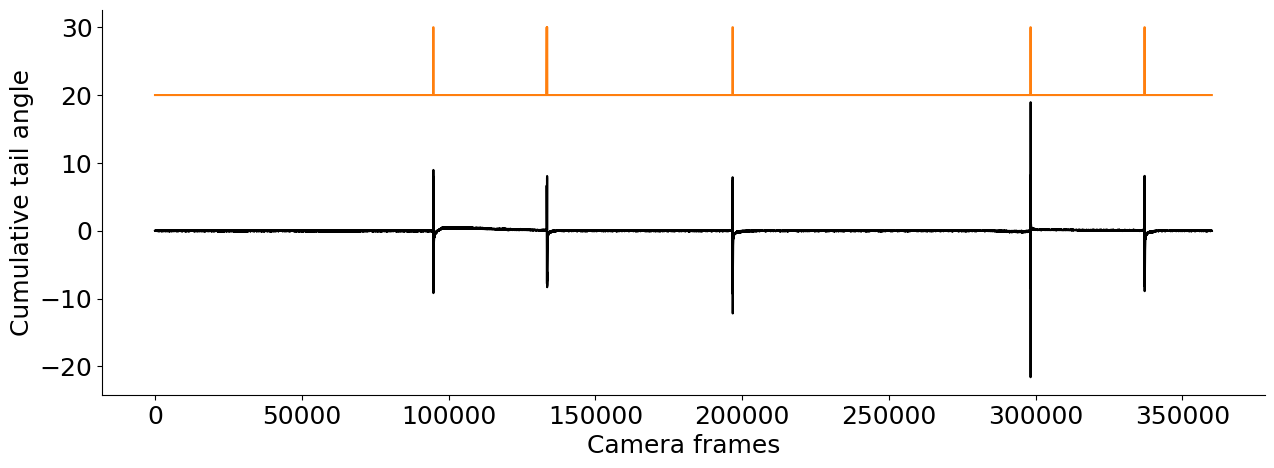

9 /media/anleg84/Backup Plus/CERVO/Data/Networks2024/20230726-Wholebrain-7dpf/20230726_18_46_39_920nm_7dpf_fish7_wholebrain/


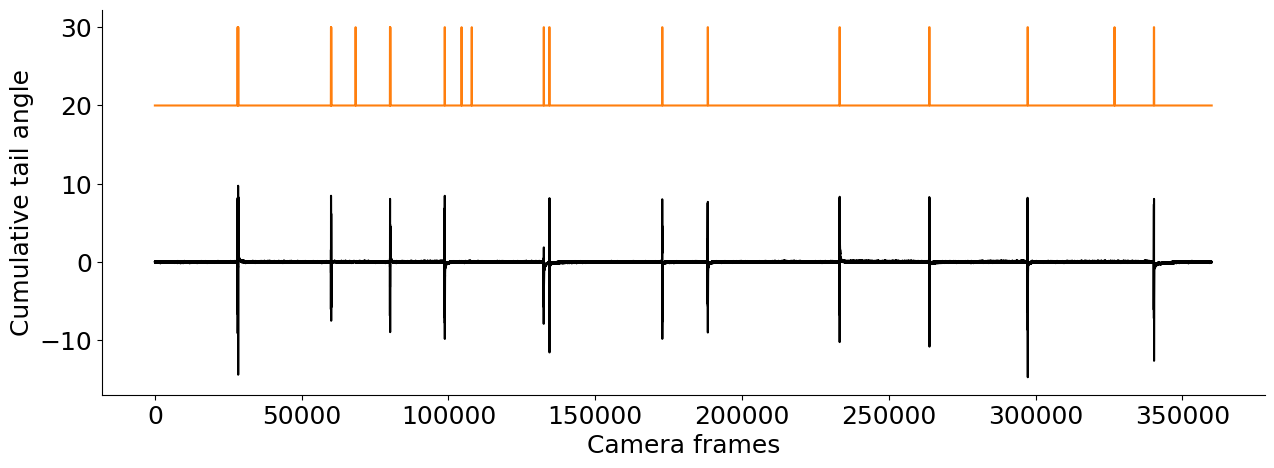

10 /media/anleg84/Backup Plus/CERVO/Data/Networks2024/20230731-Wholebrain-5dpf/20230731_10_00_19_920nm_5dpf_fish1_wholebrain/


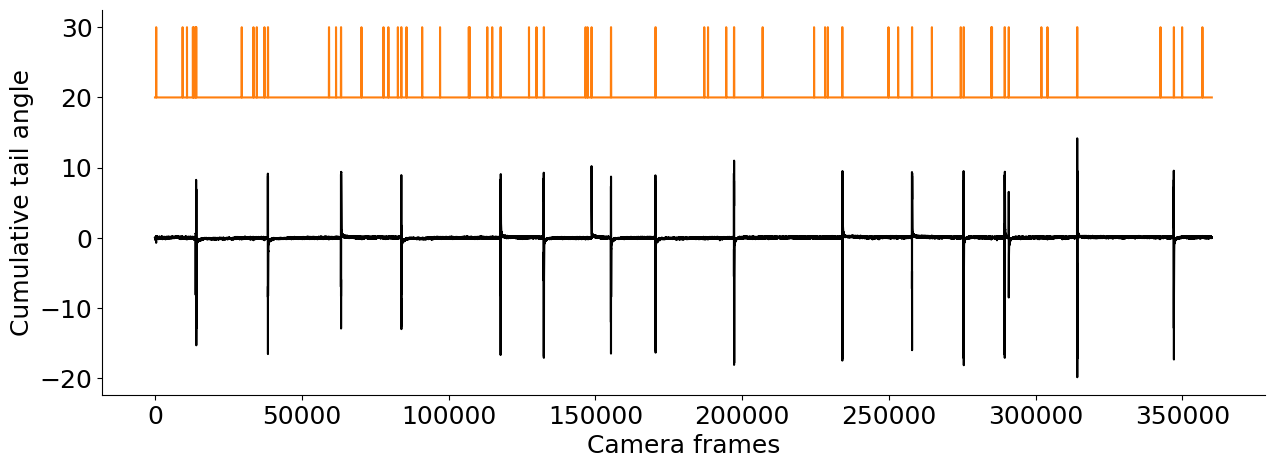

11 /media/anleg84/Backup Plus/CERVO/Data/Networks2024/20230731-Wholebrain-5dpf/20230731_11_24_56_920nm_5dpf_fish2_wholebrain/


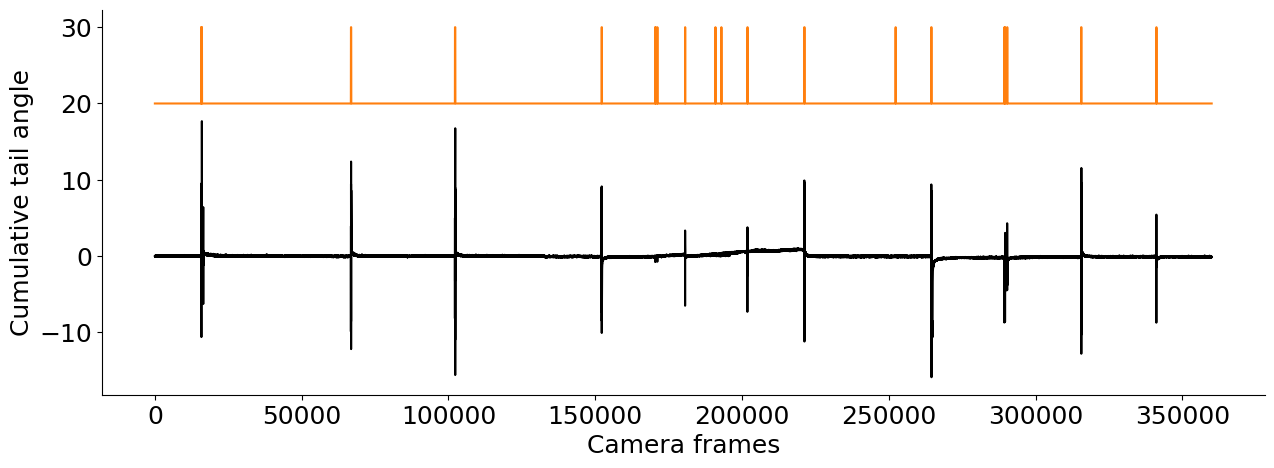

12 /media/anleg84/Backup Plus/CERVO/Data/Networks2024/20230731-Wholebrain-5dpf/20230731_12_41_39_920nm_5dpf_fish3_wholebrain/


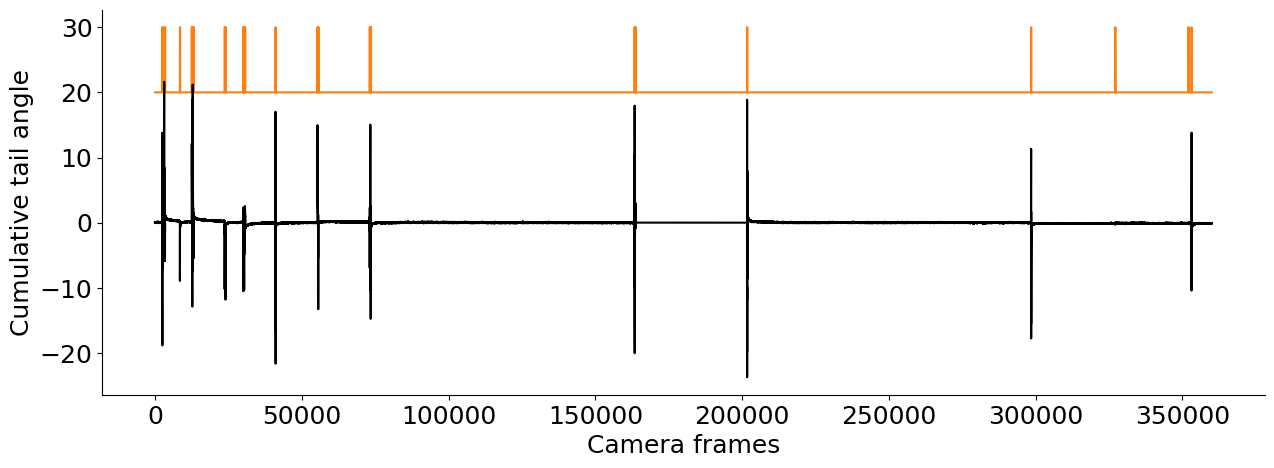

13 /media/anleg84/Backup Plus/CERVO/Data/Networks2024/20230731-Wholebrain-5dpf/20230731_14_18_39_920nm_5dpf_fish4_wholebrain/


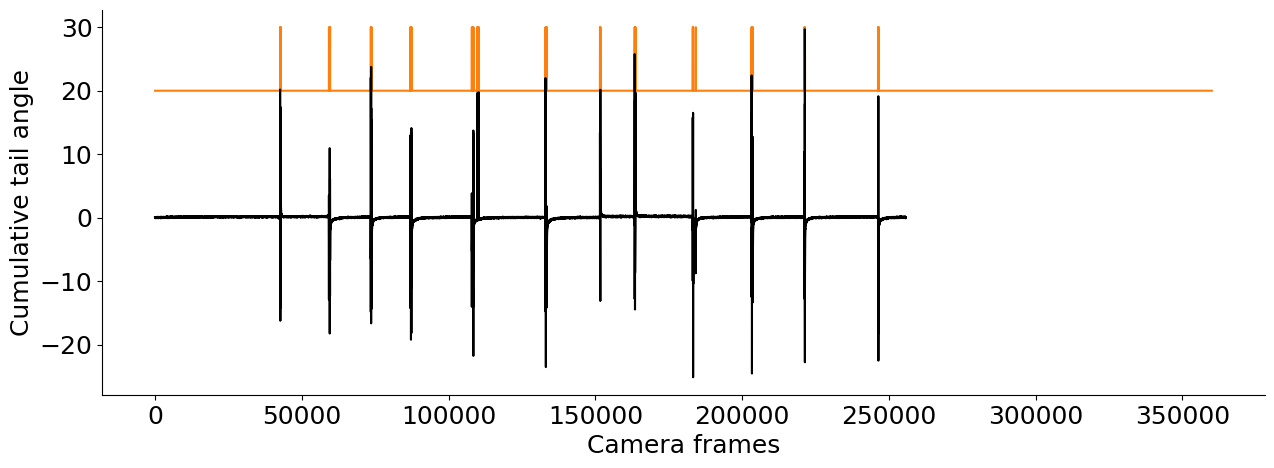

14 /media/anleg84/Backup Plus/CERVO/Data/Networks2024/20230731-Wholebrain-5dpf/20230731_15_06_20_920nm_5dpf_fish5_wholebrain/


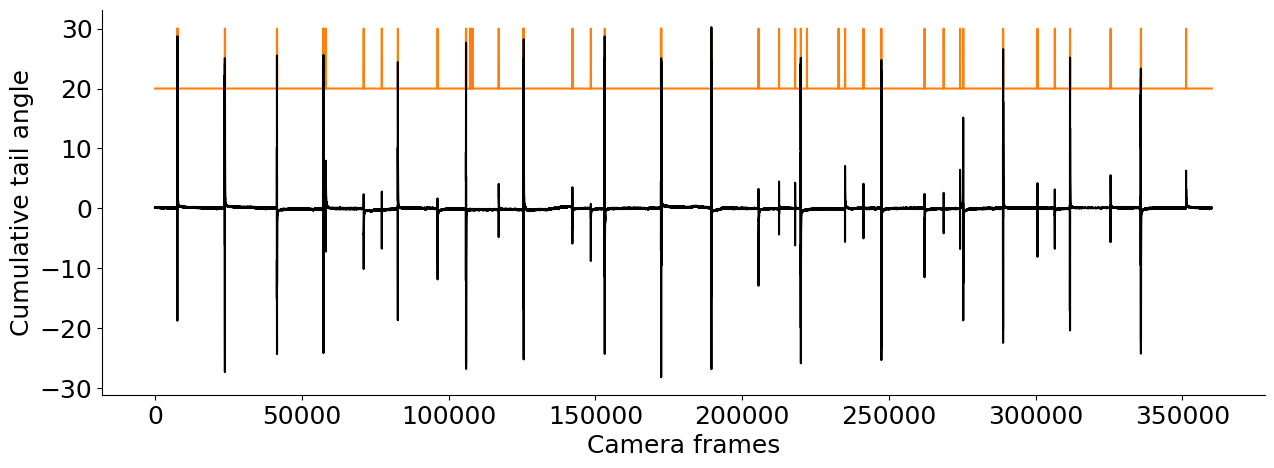

15 /media/anleg84/Backup Plus/CERVO/Data/Networks2024/20230801-Wholebrain-6dpf/20230801_11_53_46_920nm_6dpf_fish2_wholebrain/


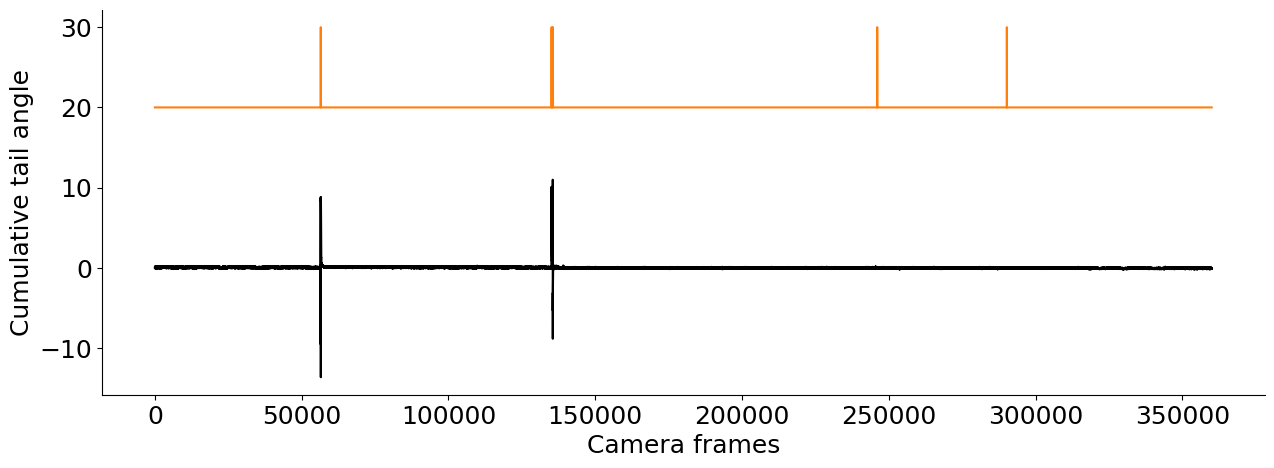

16 /media/anleg84/Backup Plus/CERVO/Data/Networks2024/20230801-Wholebrain-6dpf/20230801_13_59_36_920nm_6dpf_fish4_wholebrain/


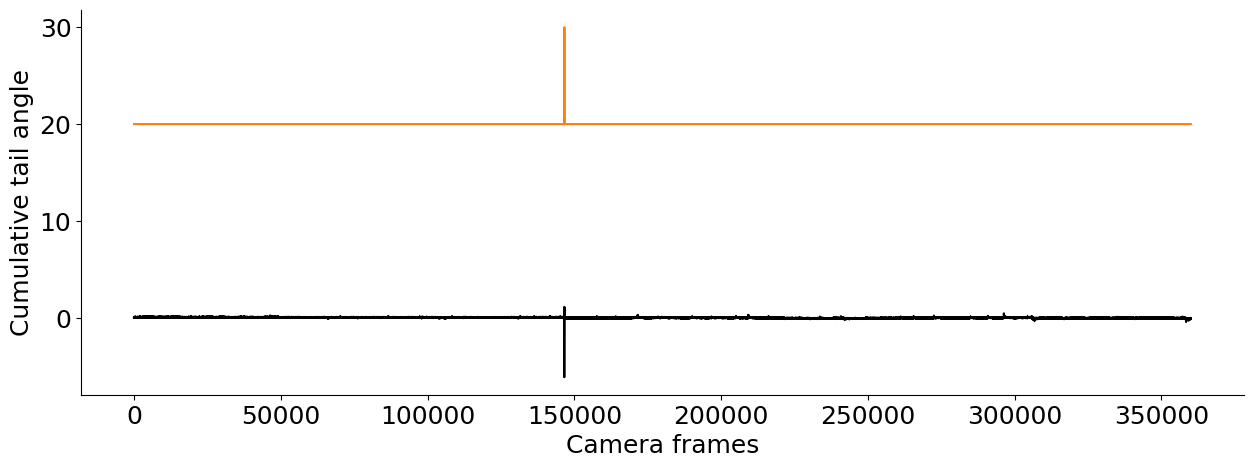

17 /media/anleg84/Backup Plus/CERVO/Data/Networks2024/20230801-Wholebrain-6dpf/20230801_15_43_21_920nm_6dpf_fish6_wholebrain/


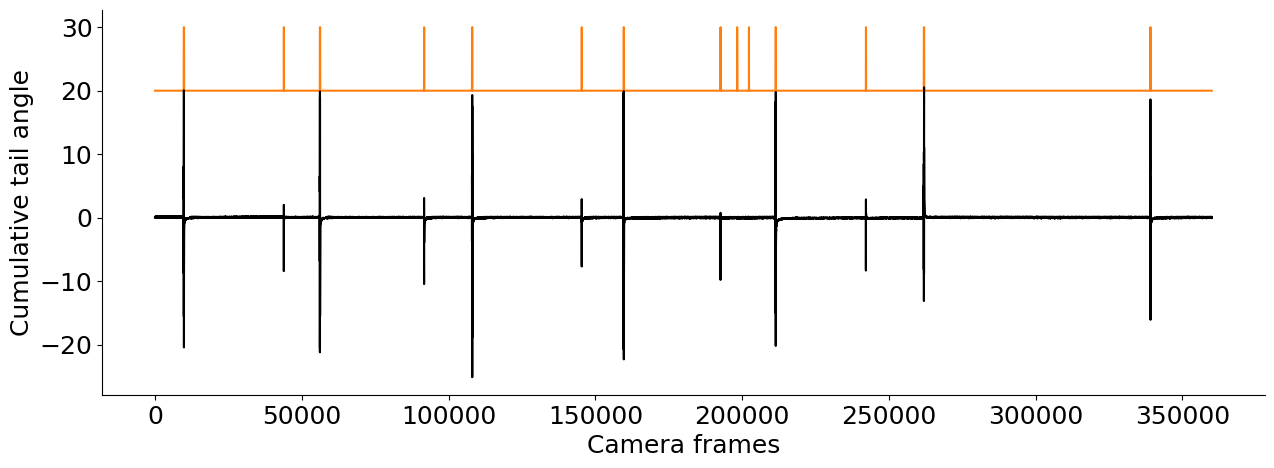

18 /media/anleg84/Backup Plus/CERVO/Data/Networks2024/20230801-Wholebrain-6dpf/20230801_16_32_40_920nm_6dpf_fish7_wholebrain/


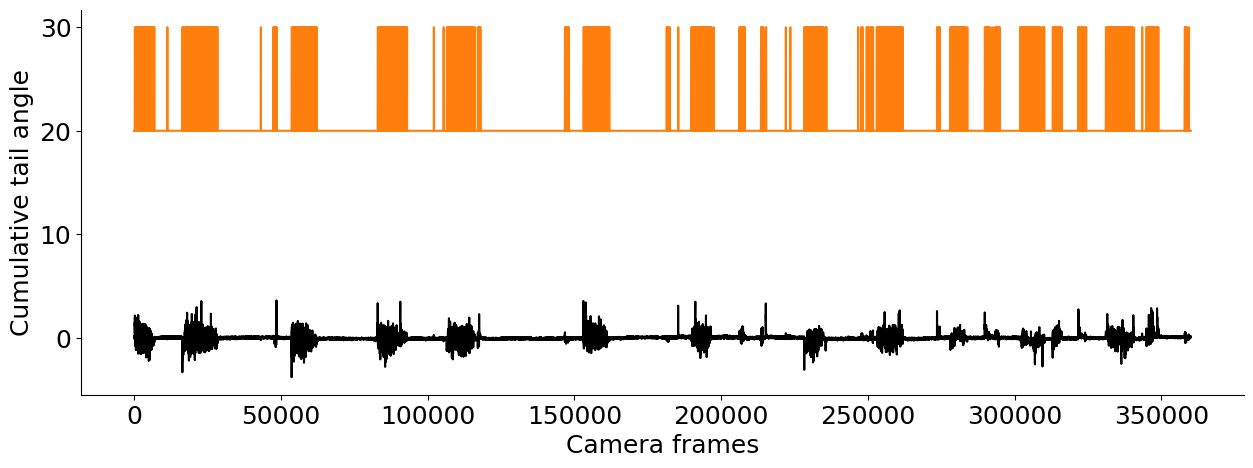

In [13]:
%matplotlib inline
for i, tail in enumerate(tails):
    
    print(i, folders[i])

    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(20 + events[i] * 10, color='C1')
    ax.plot(tail.curvature, color='black', alpha=1)
    ax.spines[['top', 'right']].set_visible(False)
    ax.set_xlabel('Camera frames')
    ax.set_ylabel('Cumulative tail angle')
    plt.show()

## Creating regressors

Now that swimming events have been identified, we generate motor regressors.

In [16]:
%matplotlib inline

def max_interpolate_signal(signal, desired_length):
    original_length = len(signal)
    bin_size = original_length / desired_length
    interpolated_signal = []
    for i in range(desired_length):
        start = int(i * bin_size)
        end = int((i + 1) * bin_size)
        max_value = max(signal[start:end])
        interpolated_signal.append(max_value)
    return np.array(interpolated_signal)

def exponential(t, tau=3.5):
    return np.exp(-1 * (t / tau))

In [17]:
i = 3
folder = folders[i]

data = load_data(folder)
t = data['timesteps']
timeseries = data['timeseries']
centroids = data['centroids']

In [18]:
tail_angles, tail_events = tails[i].angles, events[i]

We use a custom temporal downsampling procedure (from high-speed camera frames to calcium imaging microscopy frames) that preserves the maximum tail amplitude in each time bin, which we use to generate regressors of varying amplitudes.

In [21]:
diff = interpolate_signal(np.abs(np.diff(np.sum(tail_angles, axis=0))), tail_angles.shape[1])
windowed_signal = diff * tail_events
interpolated_events = max_interpolate_signal(windowed_signal, len(t))
regressor = convolve(interpolated_events, exponential(t))[:len(t)]

Text(0, 0.5, 'Fluorescence (a.u.)')

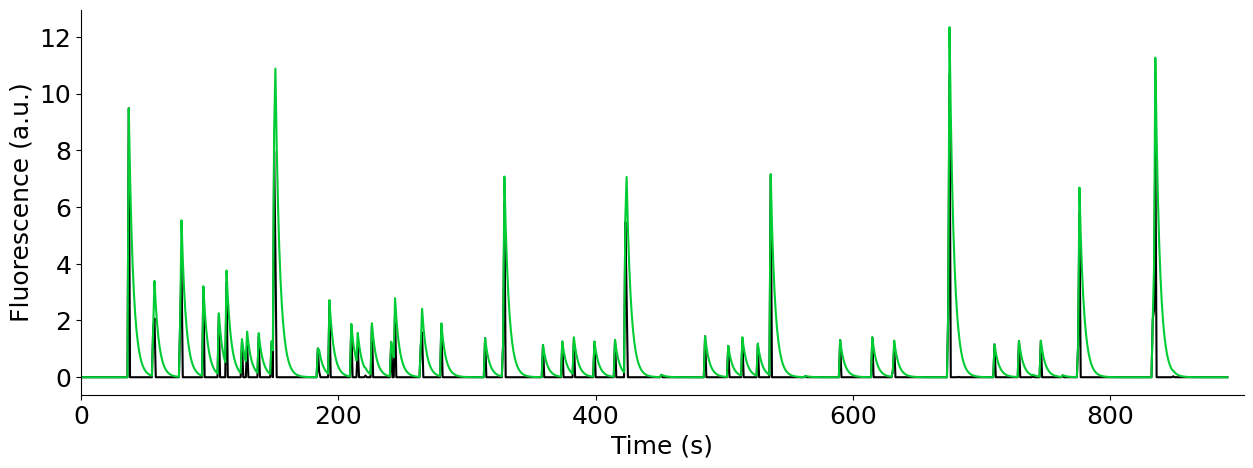

In [26]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(interpolated_events, color='black')
plt.plot(regressor, color=[0, 0.8, 0.2])
ax.spines[['top', 'right']].set_visible(False)
ax.set_xlim([0, t[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Fluorescence (a.u.)')

As can be seen here, larger swimming events yield larger calcium events. To generate null distributions, we shuffle the swimming events and generate new fake regressors.

In [27]:
shuffled_events = np.copy(interpolated_events)
np.random.shuffle(shuffled_events)
shuffled_regressor = convolve(shuffled_events, exponential(t))[:len(t)]

Text(0, 0.5, 'Fluorescence (a.u.)')

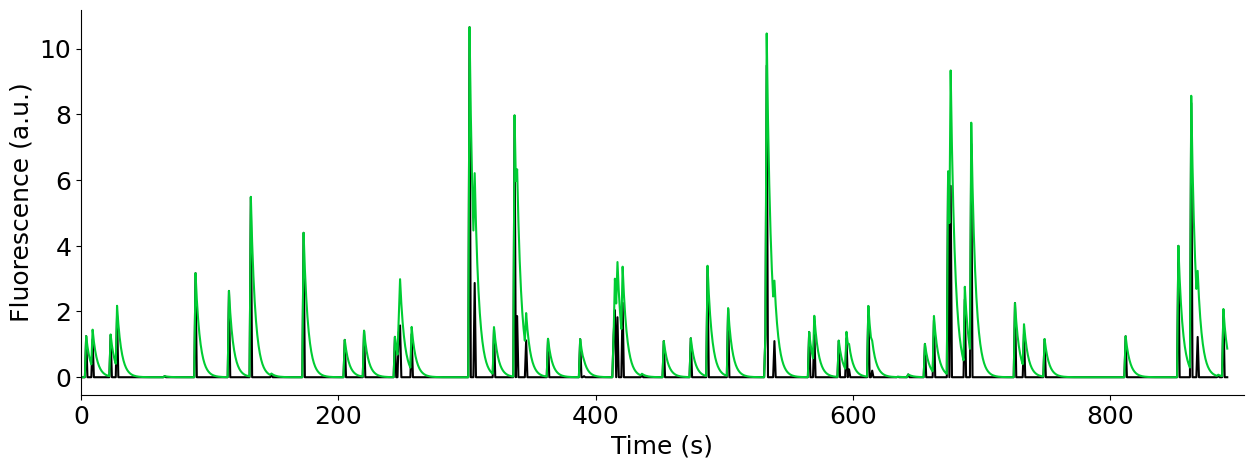

In [28]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(shuffled_events, color='black')
plt.plot(shuffled_regressor, color=[0, 0.8, 0.2])
ax.spines[['top', 'right']].set_visible(False)
ax.set_xlim([0, t[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Fluorescence (a.u.)')

Below, we can see that the varying amplitudes assumption works well, and we can recover calcium traces that match the regressor.

In [29]:
@njit
def correlate_timeseries(timeseries, regressor):
    correlations = []
    for i in range(timeseries.shape[0]):
        correlations.append(np.corrcoef(timeseries[i], regressor)[0, 1])
    return np.array(correlations)

In [30]:
correlations = correlate_timeseries(timeseries, regressor)

In [31]:
order = np.flip(np.argsort(correlations))

Text(0, 0.5, 'Fluorescence (a.u.)')

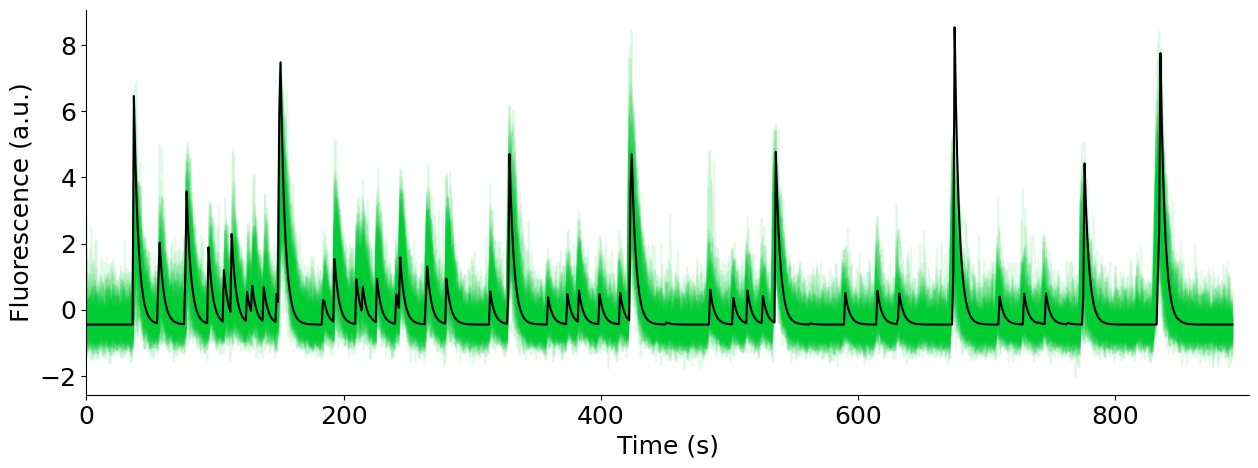

In [32]:
fig, ax = plt.subplots(figsize=(15, 5))
for i in range(100):
    plt.plot(zscore(timeseries[order][i]), color=[0, 0.8, 0.2], alpha=0.1)
plt.plot(zscore(regressor), color='black')
ax.spines[['top', 'right']].set_visible(False)
ax.set_xlim([0, t[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Fluorescence (a.u.)')

## Motor regression on all fish

Here, we apply regression on all animals, repeating most of the cells above in a single loop. We generate a null correlation distribution by shuffling regressors 250 times and correlating them with single-neuron time series.

In [36]:
camera_fps = 399.75

In [ ]:
for folder in folders:
        
    print(folder)
    data = load_data(folder)

    t = data['timesteps']
    timeseries = data['timeseries']
    centroids = data['centroids']
    
    dff = np.zeros(timeseries.shape)
    for i in tqdm(range(timeseries.shape[0]), file=sys.stdout):
        baseline = baseline_minfilter(timeseries[i], window=300, sigma1=3, sigma2=60)
        dff[i] = (timeseries[i] - baseline) / baseline
    timeseries = dff

    file = identify_files(folder, ['angles', '.npy'])[0]
    angles = np.load(folder + file)
    tail = TailAnalysis(angles, camera_fps)
    tail_events = np.load(folder + 'swim_events.npy')
    tail_angles = tail.angles

    diff = interpolate_signal(np.abs(np.diff(np.sum(tail_angles, axis=0))), tail_angles.shape[1])
    windowed_signal = diff * tail_events
    if len(windowed_signal) != 360000: # One of the larvae has a truncated tail recording. Filling missing data with zeros
        windowed_signal = np.concatenate([windowed_signal, [0] * (360000 - len(windowed_signal))])
    interpolated_events = max_interpolate_signal(windowed_signal, len(t))
    regressor = convolve(interpolated_events, exponential(t))[:len(t)]

    correlations = correlate_timeseries(timeseries, regressor)
    order = np.flip(np.argsort(correlations))
    fig, ax = plt.subplots(figsize=(15, 5))
    for i in range(100):
        plt.plot(zscore(timeseries[order][i]), color=[0, 0.8, 0.2], alpha=0.1)
    plt.plot(zscore(regressor), color='black')
    ax.spines[['top', 'right']].set_visible(False)
    ax.set_xlim([0, t[-1]])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Fluorescence (a.u.)')
    plt.show()

    perc_positive_shuffled, perc_negative_shuffled = [], []
    perc_positive_shuffled_2, perc_negative_shuffled_2 = [], []

    shuffled_events = np.copy(interpolated_events)
    for _ in tqdm(range(250), file=sys.stdout):
        np.random.shuffle(shuffled_events)
        shuffled_regressor = convolve(shuffled_events, exponential(t))[:len(t)]
        corrs_shuffled = correlate_timeseries(timeseries, shuffled_regressor)
        perc_positive_shuffled.append(np.percentile(corrs_shuffled, 99))
        perc_negative_shuffled.append(np.percentile(corrs_shuffled, 1))
        perc_positive_shuffled_2.append(np.percentile(corrs_shuffled, 99.9))
        perc_negative_shuffled_2.append(np.percentile(corrs_shuffled, 0.1))

    np.save('threshold1_motor_pos.npy', np.mean(perc_positive_shuffled))
    np.save('threshold1_motor_neg.npy', np.mean(perc_positive_shuffled))
    np.save('threshold2_motor_pos.npy', np.mean(perc_positive_shuffled_2))
    np.save('threshold2_motor_neg.npy', np.mean(perc_positive_shuffled_2))

    motor_cells = correlations > np.mean(perc_positive_shuffled_2)
    antimotor_cells = correlations < np.mean(perc_negative_shuffled_2)
    
    plt.figure(figsize=(4, 6), dpi=150)
    plt.imshow(np.max(data['average_frames'], axis=0), cmap='gray', vmax=30000)
    plt.scatter(centroids[motor_cells, 1], centroids[motor_cells, 0], color=[0, 0.9, 0.1], edgecolor='none', alpha=0.5, s=10)
    plt.axis('off')
    plt.show()

    np.save(folder + 'correlations_motor.npy', correlations)
    np.save(folder + 'correlated_motor.npy', motor_cells)
    np.save(folder + 'anticorrelated_motor.npy', antimotor_cells)

## Stimulus regression on all fish

Next, we identify visually responsive neurons by generating regressors of light and dark responses. The stimulus sequence is encoded in the `sequence` vector loaded below, which is then used to construct the regressors. In this case, the null correlation distribution is generated by correlating the regressor with spontaneous activity, where no visual stimuli are present.

In [ ]:
sequence = np.load('Data/sequence_15mins_light_darkflash.npy')

In [ ]:
for folder in datasets:

    print(folder)
    data = load_data(folder)
    timeseries = np.load(folder + 'dff.npy')
    centroids = data['centroids']
    centroids_atlas = data['centroids_atlas']
    t = data['timesteps']

    T = len(np.where(t >= 600)[0])
    regression = Regressors(sequence[600:], fps=1)
    regression.set_reference_timestamps(data['timesteps'][:T])
    regression.create_regressor('dark', ['dark'])
    regression.create_regressor('light', ['light'])

    correlations_null = regression.correlate(timeseries[:, 100:100 + T], 'dark')
    correlations = regression.correlate(timeseries[:, -T:], 'dark')
    np.save(folder + 'correlations_dark.npy', correlations)
    thresh = np.percentile(correlations_null, 99)
    correlated_dark = correlations >= thresh

    correlations_null = regression.correlate(timeseries[:, 100:100 + T], 'light')
    correlations = regression.correlate(timeseries[:, -T:], 'light')
    np.save(folder + 'correlations_light.npy', correlations)
    thresh = np.percentile(correlations_null, 99)
    correlated_light = correlations >= thresh

    plt.figure(figsize=(4, 6), dpi=150)
    plt.imshow(np.max(data['average_frames'], axis=0), cmap='gray', vmax=30000)
    plt.scatter(centroids[correlated_dark, 1], centroids[correlated_dark, 0], color='red', edgecolor='none', alpha=0.5, s=10)
    plt.scatter(centroids[correlated_light, 1], centroids[correlated_light, 0], color='yellow', edgecolor='none', alpha=0.5, s=10)
    plt.axis('off')
    plt.show()
    
    signal = np.mean(timeseries[correlated_dark], axis=0)
    plt.figure(figsize=(15, 3))
    plt.plot(normalize(signal[-T-1:-1]), color='red')
    plt.plot(regression.regressors['dark'] + 0.1, color='black')
    plt.axis('off')
    plt.xlim([50, 250])
    plt.show()

    signal = np.mean(timeseries[correlated_light], axis=0)
    plt.figure(figsize=(15, 3))
    plt.plot(normalize(signal[-T-1:-1]), color='gold')
    plt.plot(regression.regressors['light'] + 0.1, color='black')
    plt.axis('off')
    plt.xlim([50, 250])
    plt.show()

    np.save(folder + 'correlated_dark.npy', correlated_dark)
    np.save(folder + 'correlated_light.npy', correlated_light)

# Part 2 - Brain mapping

Now that we have identified which cells are significantly correlated with independent motor and visual variables, we generate whole-brain maps by plotting neuron coordinates in the brain atlas, colored by arbitrary spatial density units.

### Loading motor cells

In [5]:
centroids1, motor_labels, antimotor_labels = [], [], []

for folder in tqdm(folders, file=sys.stdout):
    
    data = load_data(folder)
    data['region_labels'][:, 10] = 0
    in_brain = np.sum(data['region_labels'], axis=1) > 0
    motor_cells = np.load(folder + 'correlated_motor.npy')
    antimotor_cells = np.load(folder + 'anticorrelated_motor.npy')
    
    centroids1.append(data['centroids_atlas'][in_brain])
    motor_labels.append(motor_cells[in_brain])
    antimotor_labels.append(antimotor_cells[in_brain])

centroids_motor = np.concatenate(centroids1, axis=0)[np.concatenate(motor_labels) == True]
centroids_antimotor = np.concatenate(centroids1, axis=0)[np.concatenate(antimotor_labels) == True]

100%|███████████████████████████████████████████| 19/19 [01:39<00:00,  5.25s/it]


### Loading stimulus cells

In [6]:
centroids2, dark_labels, light_labels = [], [], []

for folder in tqdm(datasets, file=sys.stdout):
    
    data = load_data(folder)
    data['region_labels'][:, 10] = 0
    in_brain = np.sum(data['region_labels'], axis=1) > 0
    dark_cells = np.load(folder + 'correlated_dark.npy')
    light_cells = np.load(folder + 'correlated_light.npy')

    centroids2.append(data['centroids_atlas'][in_brain])
    dark_labels.append(dark_cells[in_brain])
    light_labels.append(light_cells[in_brain])

centroids_dark = np.concatenate(centroids2, axis=0)[np.concatenate(dark_labels) == True]
centroids_light = np.concatenate(centroids2, axis=0)[np.concatenate(light_labels) == True]

100%|███████████████████████████████████████████| 22/22 [00:22<00:00,  1.03s/it]


### Visualizing cell densities

Motor cells.

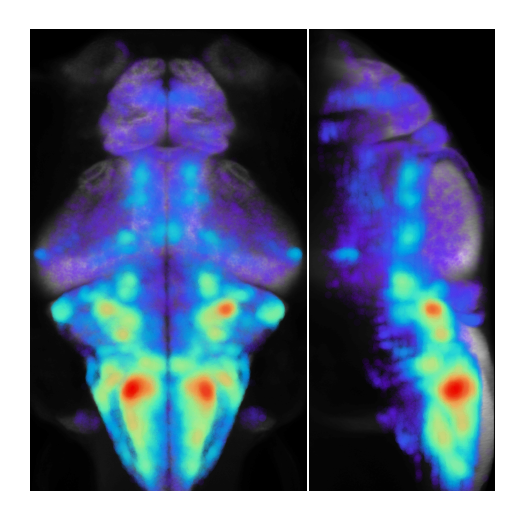

In [7]:
plot_centroids_on_atlas(centroids_motor, atlas, alpha=0.05, density=True, cmap='rainbow')

Anti-motor cells.

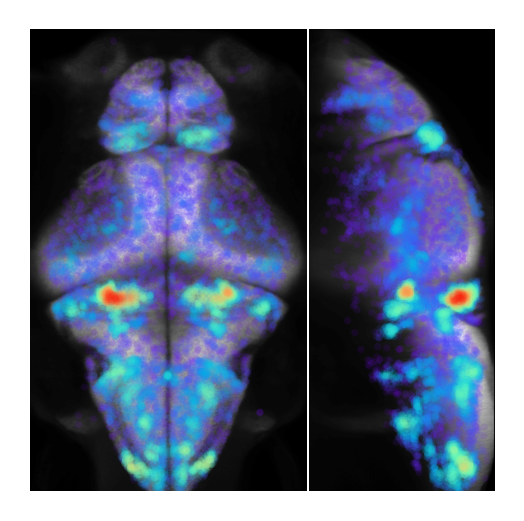

In [8]:
plot_centroids_on_atlas(centroids_antimotor, atlas, alpha=0.1, density=True, cmap='rainbow')

Dark cells.

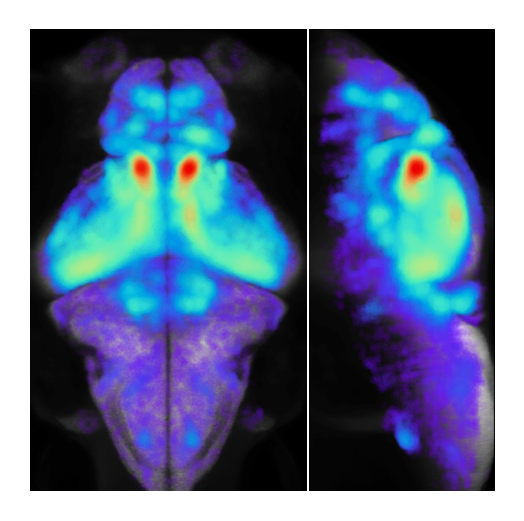

In [9]:
plot_centroids_on_atlas(centroids_dark, atlas, alpha=0.05, density=True, cmap='rainbow')

Light cells.

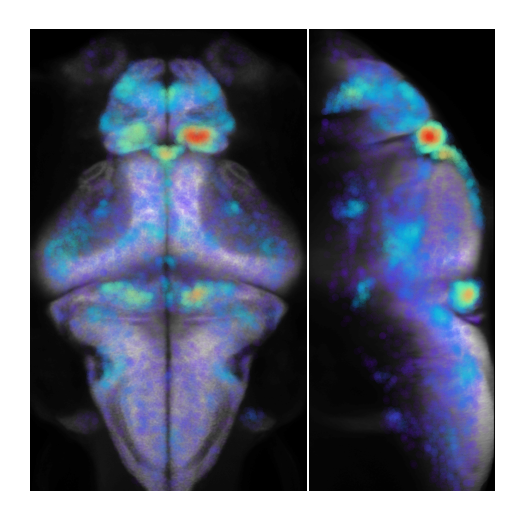

In [10]:
plot_centroids_on_atlas(centroids_light, atlas, alpha=0.05, density=True, cmap='rainbow')

### Applying spatial P-value test

The spatial densities above contain many cells throughout the brain, with many sparse and low-density regions. The following spatial P-value analysis (detailed in Methods) excludes such cells based on a spatial statistical criterion evaluated across all animals.

In [7]:
compute = False

if compute:
    p_motor = np.concatenate(spatial_p_value_test(centroids1, motor_labels, N_shuffles=1000))
    p_antimotor = np.concatenate(spatial_p_value_test(centroids1, antimotor_labels, N_shuffles=1000))
    p_dark = np.concatenate(spatial_p_value_test(centroids2, dark_labels, N_shuffles=1000))
    p_light = np.concatenate(spatial_p_value_test(centroids2, light_labels, N_shuffles=1000))
    np.save('Results/figure5_pvalues_motor.npy', p_motor)
    np.save('Results/figure5_pvalues_antimotor.npy', p_antimotor)
    np.save('Results/figure5_pvalues_dark.npy', p_dark)
    np.save('Results/figure5_pvalues_light.npy', p_light)
else:
    p_motor = np.load('Results/figure5_pvalues_motor.npy')
    p_antimotor = np.load('Results/figure5_pvalues_antimotor.npy')
    p_dark = np.load('Results/figure5_pvalues_dark.npy')
    p_light = np.load('Results/figure5_pvalues_light.npy')

In [8]:
significance = 0.025
density = True

Motor cells.

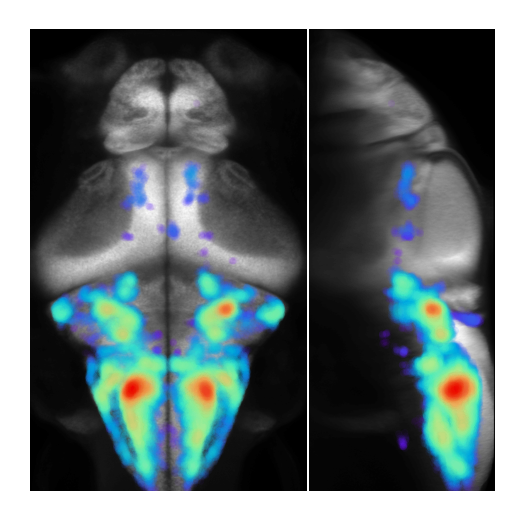

In [9]:
plot_centroids_on_atlas(centroids_motor[p_motor < significance], atlas, alpha=0.05, density=True, cmap='rainbow')

Anti-motor cells.

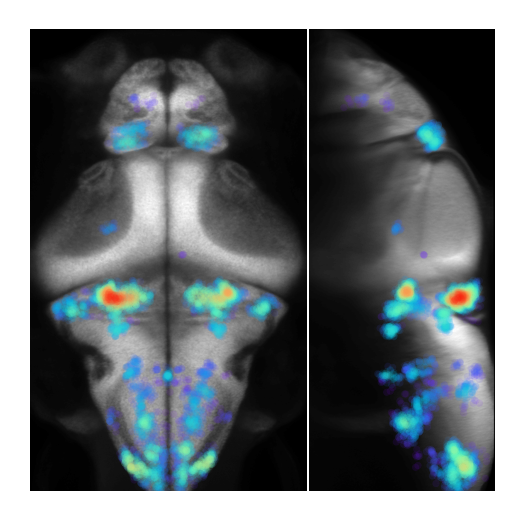

In [10]:
plot_centroids_on_atlas(centroids_antimotor[p_antimotor < significance], atlas, alpha=0.1, density=True, cmap='rainbow')

Dark cells.

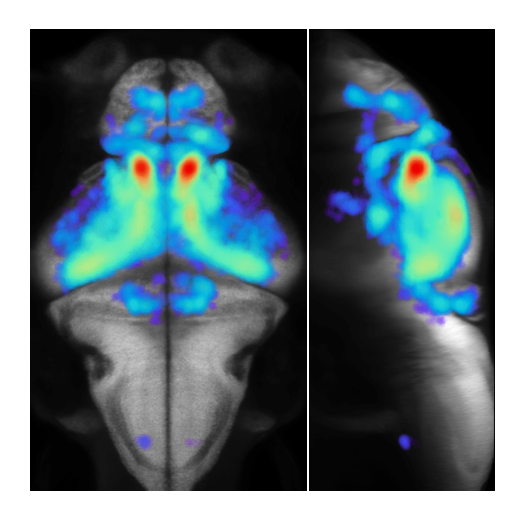

In [11]:
plot_centroids_on_atlas(centroids_dark[p_dark < significance], atlas, alpha=0.05, density=True, cmap='rainbow')

Light cells.

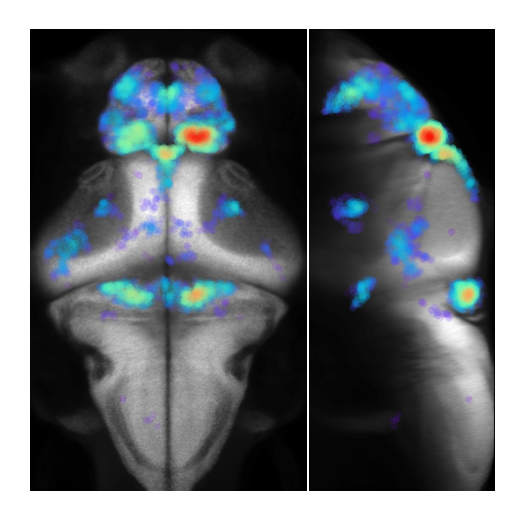

In [12]:
plot_centroids_on_atlas(centroids_light[p_light < significance], atlas, alpha=0.1, density=True, cmap='rainbow')

In [14]:
np.save('Results/figure5_centroids_dark.npy', centroids_dark)
np.save('Results/figure5_centroids_light.npy', centroids_light)
np.save('Results/figure5_centroids_motor.npy', centroids_motor)
np.save('Results/figure5_centroids_antimotor.npy', centroids_antimotor)

As we can see, only the high-density regions are preserved.

# Generating .tif density stacks

Here, we generate stacks with filtered neuron coordinates for visualization in ImageJ and 3D rendering.

In [21]:
density = atlas.generate_centroid_density(centroids_motor[p_motor < significance])
filtered = gaussian_filter(density, 2)
save_stack('Results/figure5_density_motor_thresholded.tif', filtered)

density = atlas.generate_centroid_density(centroids_antimotor[p_antimotor < significance])
filtered = gaussian_filter(density, 2)
save_stack('Results/figure5_density_antimotor_thresholded.tif', filtered)

density = atlas.generate_centroid_density(centroids_dark[p_dark < significance])
filtered = gaussian_filter(density, 2)
save_stack('Results/figure5_density_dark_thresholded.tif', filtered)

density = atlas.generate_centroid_density(centroids_light[p_light < significance])
filtered = gaussian_filter(density, 2)
save_stack('Results/figure5_density_light_thresholded.tif', filtered)

# Studying overlap between populations

We now evaluate how different sensorimotor populations intersect.

In [5]:
centroids, regions = [], []
labels_motor, labels_antimotor, labels_light, labels_dark = [], [], [], []

for folder in tqdm(folders, file=sys.stdout):
    
    data = load_data(folder)
    data['region_labels'][:, 10] = 0
    in_brain = np.sum(data['region_labels'], axis=1) > 0

    motor_cells = np.load(folder + 'correlated_motor.npy')
    antimotor_cells = np.load(folder + 'anticorrelated_motor.npy')
    dark_cells = np.load(folder + 'correlated_dark.npy')
    light_cells = np.load(folder + 'correlated_light.npy')
    
    centroids.append(data['centroids_atlas'][in_brain])
    regions.append(data['region_labels'][in_brain])
    labels_dark.append(dark_cells[in_brain])
    labels_light.append(light_cells[in_brain])
    labels_motor.append(motor_cells[in_brain])
    labels_antimotor.append(antimotor_cells[in_brain])

100%|███████████████████████████████████████████| 19/19 [01:46<00:00,  5.62s/it]


In [6]:
labels = [labels_motor, labels_antimotor, labels_dark, labels_light]
overlap_matrix = np.zeros((len(centroids), 4, 4))

for i in range(len(folders)):
    for i1 in range(overlap_matrix.shape[1]):
        for i2 in range(overlap_matrix.shape[1]):
            overlap = np.sum(labels[i1][i] * labels[i2][i])
            overlap_matrix[i, i1, i2] = overlap

Computing maximal overlaps

In [13]:
avg_overlap = np.mean(overlap_matrix[:-1], axis=0)

In [14]:
np.max(np.log(np.mean(overlap_matrix, axis=0) + 1))

8.378608450604185

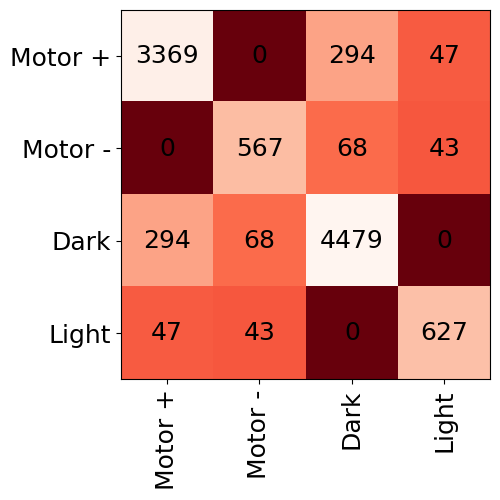

In [15]:
plt.imshow(np.log(np.mean(overlap_matrix[:-1], axis=0) + 1), cmap='Reds_r')
plt.xticks([0, 1, 2, 3], ['Motor +', 'Motor -', 'Dark', 'Light'], rotation=90)
plt.yticks([0, 1, 2, 3], ['Motor +', 'Motor -', 'Dark', 'Light'])
for i in range(4):
    for j in range(4):
        plt.text(i, j, int(avg_overlap[i, j]), ha='center', va='center')
plt.show()

The matrix above indicates, on the diagonal, how many cells a present per category and per animal on average. Off-diagonal are shown the number of neurons that belong to multiple categories at once. By definition, light and dark neurons are temporally anticorrelated and there is no population overlap. Same thing for motor + and motor - cells.

In [10]:
max_overlaps = []
for i in range(4):
    values = []
    for j in range(4):
        if j != i:
            values.append(avg_overlap[i, j])
    max_overlaps.append(np.max(values))
max_overlaps = np.array(max_overlaps)
max_overlap_fraction = max_overlaps / np.diag(avg_overlap)

In [11]:
max_overlap_fraction

array([0.07810751, 0.12373528, 0.06834206, 0.14029417])

In [16]:
np.save('Results/figure5_overlap_matrices.npy', overlap_matrix)

# Spatial density of overlapping cells

Here, we compile all neurons that belong to multiple functional categories, and we generate a consensus spatial density.

In [17]:
significance = 0.025

In [18]:
labels_polyfunctional = []

for i in range(len(labels_dark)):
    l = np.zeros((centroids[i].shape[0], ))
    l[labels_dark[i] * labels_motor[i]] = 1
    l[labels_dark[i] * labels_antimotor[i]] = 1
    l[labels_light[i] * labels_motor[i]] = 1
    l[labels_light[i] * labels_antimotor[i]] = 1
    labels_polyfunctional.append(l.astype('bool'))

In [28]:
p_polyfunctional = np.concatenate(spatial_p_value_test(centroids, labels_polyfunctional, N_shuffles=1000))

100%|███████████████████████████████████████████| 19/19 [00:58<00:00,  3.08s/it]


In [29]:
centroids_polyfunctional = np.concatenate(get_centroids_from_labels(centroids, labels_polyfunctional))

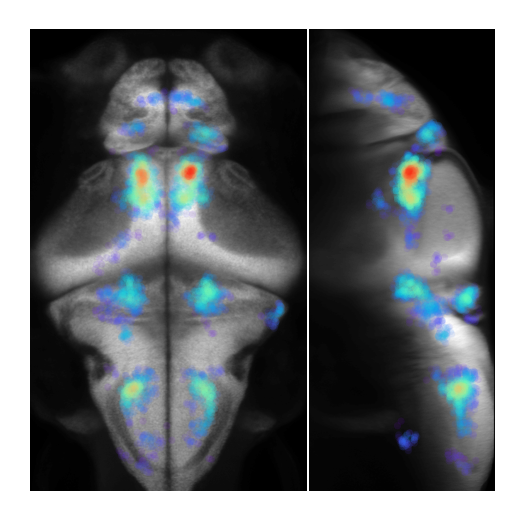

In [35]:
plot_centroids_on_atlas(centroids_polyfunctional[p_polyfunctional < significance], atlas, alpha=0.1, density=True, cmap='rainbow')

In [21]:
np.save('Results/supp_labels_dark.npy', np.concatenate(labels_dark))
np.save('Results/supp_labels_light.npy', np.concatenate(labels_light))
np.save('Results/supp_labels_motor.npy', np.concatenate(labels_motor))
np.save('Results/supp_labels_antimotor.npy', np.concatenate(labels_antimotor))
np.save('Results/supp_centroids_polyfunctional.npy', np.concatenate(centroids, axis=0))

In [33]:
np.save('Results/figure5_centroids_polyfunctional.npy', centroids_polyfunctional[p_polyfunctional < significance])

# Regional diversity

We finish by evaluating the regional diversity of functionally-defined cells. This is accomplished using a simple entropy measure, where equal proportions of different cell types are associated with high scores. We penalize this measure by the standard deviation across fish, which penalizes regions with high variability.

#### All correlated cells (no spatial P-value)

In [16]:
def shannon_diversity(proportions):
    H = 0
    for p in proportions:
        if p != 0:
            H += -1 * p * np.log(p)
    return H

def smooth_counts(counts, alpha=1):
    """Uses additive smoothing to smooth integer counts. Input array is shaped (d x M), where d is the number of categories,
    and M are independent replicates of a certain measures."""
    smoothed = np.zeros(counts.shape)
    d = counts.shape[0]
    for i in range(smoothed.shape[1]):
        N = np.sum(counts[:, i])
        for j in range(counts.shape[0]):
            smoothed[j, i] = N * ((counts[j, i] + alpha) / (N + (alpha * d)))
    return smoothed

def compute_counts_per_region(category_labels, region_labels):
    
    N_individuals = len(category_labels[0])
    N_categories = len(category_labels)
    N_regions = region_labels[0].shape[1]
    counts_matrix = np.zeros((N_individuals, N_categories, N_regions))
    
    for i in range(N_individuals):
        for j in range(N_categories):
            for k in range(N_regions):
                l = category_labels[j][i]
                r = region_labels[i][:, k]
                counts_matrix[i, j, k] = np.sum(l[r > 0])
    
    return counts_matrix

def compute_proportions(counts):
    proportions = np.zeros(counts.shape)
    for i in range(proportions.shape[1]):
        s = np.sum(counts[:, i])
        if s != 0:
            proportions[:, i] = counts[:, i] / s
    return proportions

def compute_diversity(proportions):
    diversity = []
    for i in range(proportions.shape[1]):
        if np.sum(proportions[:, i]) != 0:
            div = shannon_diversity(proportions[:, i])
            diversity.append(div)
        else:
            diversity.append(0)
    diversity = np.array(diversity)
    return diversity

In [17]:
N_neurons_per_region = np.mean(np.load('Results/N_neurons_per_region.npy'), axis=0)
N_neurons_per_region[N_neurons_per_region == 0] = 1
excluded = np.load('Results/excluded_regions.npy')

In [18]:
counts_matrix = compute_counts_per_region(labels, regions)

In [20]:
counts_matrix.shape

(19, 4, 70)

In [21]:
diversities = []
for i in range(counts_matrix.shape[0]):
    c = counts_matrix[i]
    p = compute_proportions(c)
    d = compute_diversity(p)
    diversities.append(d)

In [23]:
diversities = np.stack(diversities)

In [24]:
diversity_std = np.std(diversities, axis=0)
diversity_mean = np.mean(diversities, axis=0)

In [19]:
diversity_std[diversity_std == 0] = 1

In [20]:
adjusted_diversity = diversity_mean / diversity_std

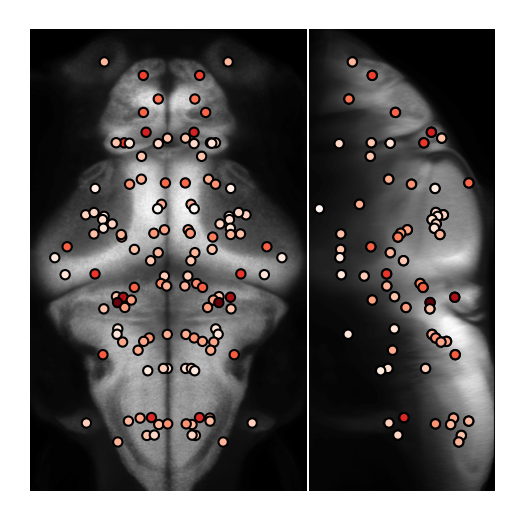

In [21]:
plot_regional_values(np.delete(adjusted_diversity, excluded), atlas, excluded=excluded, double_vector=True, cmap='Reds')
%matplotlib inline

In [25]:
np.save('Results/figure5_adjusted_regional_diversity.npy', adjusted_diversity)